# PCA and TSNE Analysis of Paired Dataset
### April 10 2024

PCA and TSNE analyses of pairwise dataset

In [2]:
import sklearn as sk
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification

from sklearn import tree
import pydotplus
from IPython.display import Image

from sklearn.impute import SimpleImputer

In [3]:
pairwise = [['ASD', 'AD'], ['ASD', 'PD'], ['ASD', 'MS'],
            ['AD', 'PD'], ['AD', 'MS'],
            ['PD', 'MS']]

color_map = {'AD': '#666666',
             'ASD':'#F0027F',
             'MS': '#FDC086',
             'PD': '#7FC97F'}

# load in data:
df = pd.read_csv('../Data/20440_cleaned_data.csv')

# This is for trimming out a certain amount of a diagnosis if we want more equal sizes
# for diag in diagnoses:
#     indexdiag = df[df['Diagnosis'] == diag].index
#     df = df.drop(indexdiag[50:])

# This is for dropping certain diagnoses for troubleshooting
df_pair = []

for pair in pairwise:
    df_i = df.loc[(df['Diagnosis'] == pair[0]) | (df['Diagnosis'] == pair[1])]
    df_pair.append(df_i)

# For dropping diagnosis column so we can feed data in:
data_pair = []

for dataset in df_pair:
    data_pair_i = dataset.drop(['Diagnosis'], axis=1) # data without diagnosis column
    data_pair_i = data_pair_i.drop(['Unknown'], axis=1)
    data_pair_i = data_pair_i.loc[:, (data_pair_i != 0).any(axis=0)] # delete any columns with all zeros
    data_pair.append(data_pair_i)

# make a list of diagnoses:
diagnosis_pair = []

for dataset in df_pair:
    diagnosis_pair.append(list(dataset["Diagnosis"]))
    

Imputation, if necessary:

In [4]:
# imp_mean = SimpleImputer(missing_values=0, strategy='mean')
# imp_mean.fit(data)
# out = imp_mean.transform(data)
# columns = data.columns
# data = pd.DataFrame(out, columns=columns)

Removing small relative abundances, if necessary:

In [5]:
# columns = data.columns
# for col in columns:
#     accept = 0
#     for i in data[col]:
#         if i > 1:
#             accept += 1
#     if accept < 1:
#         data = data.drop([col], axis=1)


## PCA 

**Now we perform PCA:**

**Run PCA:**

In [6]:
out_df_pair = []
var_ratio_pair = []
pcs_pair = []
for data in data_pair:
    pca = PCA(n_components=.95)
    out = pca.fit_transform(data)

    columns_list = []
    for i in range(len(out[0])):
        columns_list.append("PC" + str(i + 1))
    
    out_df = pd.DataFrame(out, columns=columns_list)
    out_df_pair.append(out_df)
    var_ratio_pair.append(pca.explained_variance_ratio_)
    pcs_pair.append(pca.components_)

**Visualize variance ratio explained by each component:**

<Figure size 1280x960 with 0 Axes>

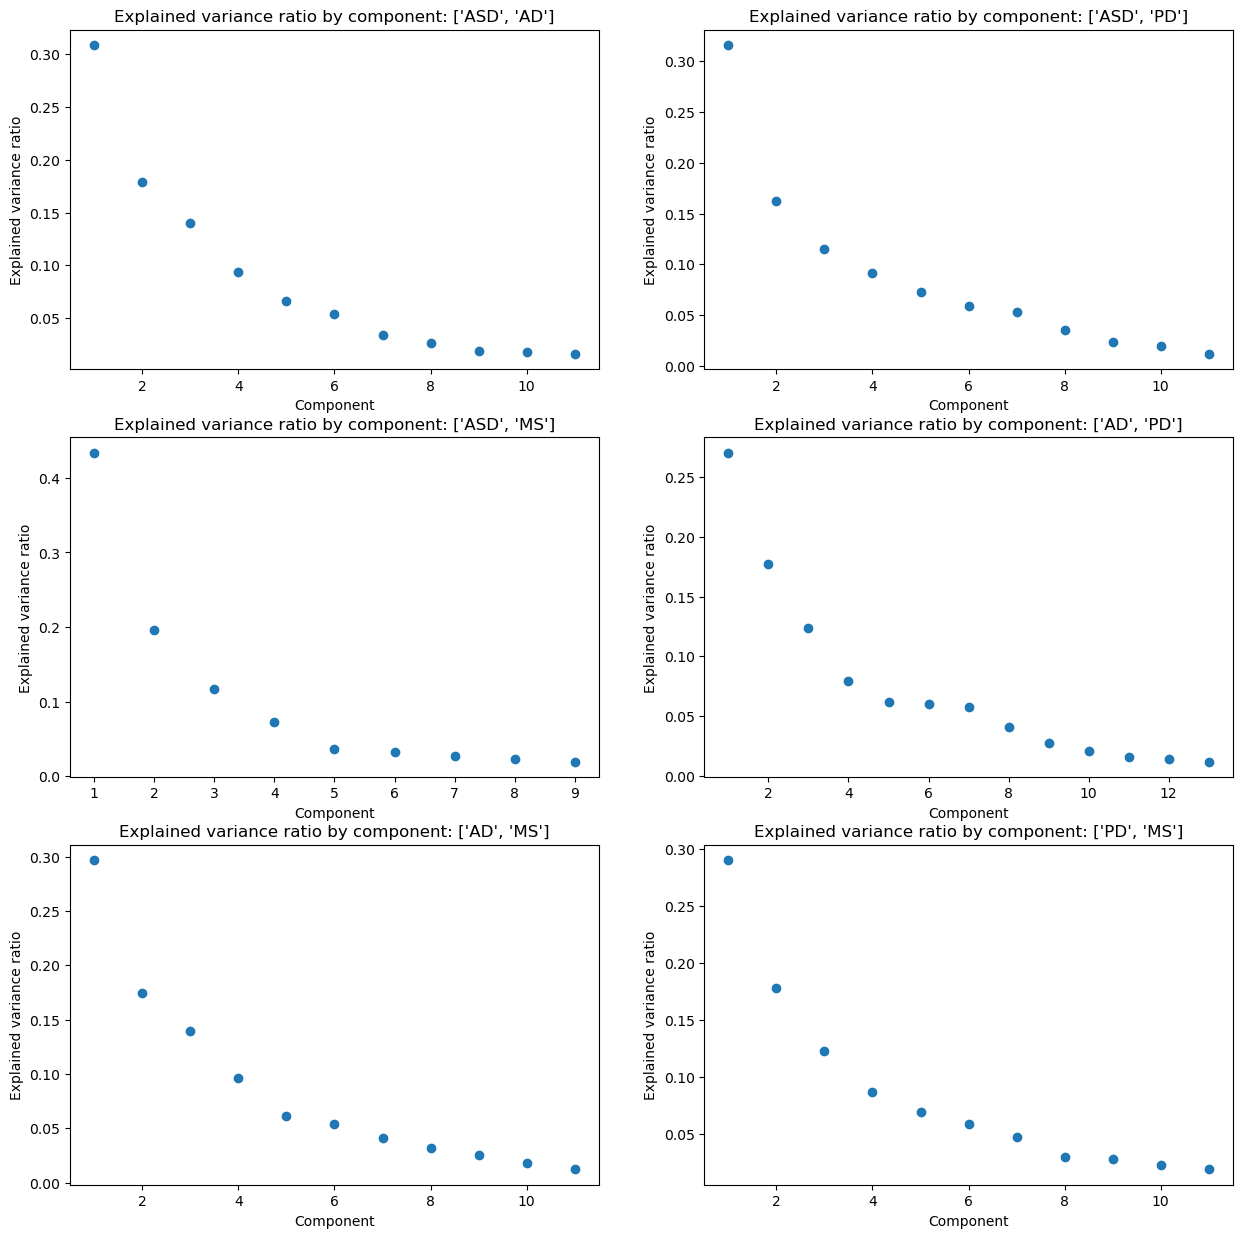

In [7]:
plt.figure(dpi = 200)
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2, figsize=(15, 15))
axes = [ax1, ax2, ax3, ax4, ax5, ax6]

for i in range(len(out_df_pair)):
    pc = np.linspace(1, len(out_df_pair[i].columns), len(out_df_pair[i].columns))
    axes[i].scatter(pc, var_ratio_pair[i])
    axes[i].set_title('Explained variance ratio by component: ' +  str(pairwise[i]))
    axes[i].set(xlabel='Component')
    axes[i].set(ylabel='Explained variance ratio');

**Visualize clustering by diagnosis with first two PCs:**

<Figure size 1280x960 with 0 Axes>

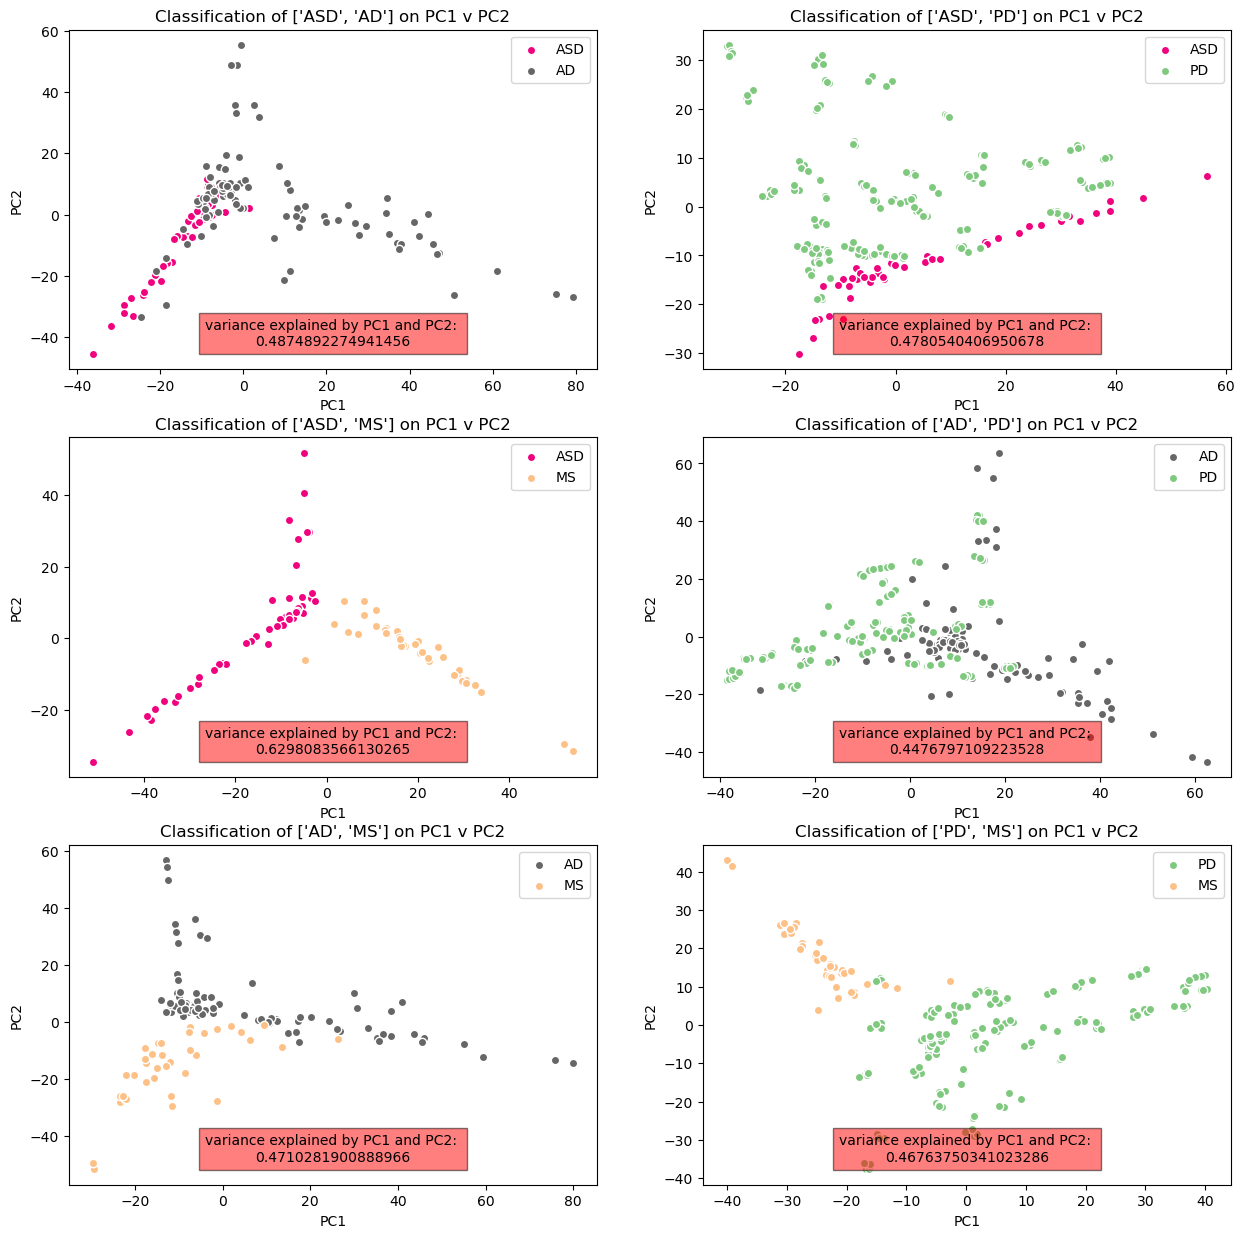

In [8]:
plt.figure(dpi = 200)
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2, figsize=(15, 15))
axes = [ax1, ax2, ax3, ax4, ax5, ax6]

for i in range(len(out_df_pair)):
    
    diag_1 = []
    diag_2 = []
    
    for j in range(len(diagnosis_pair[i])):
        if diagnosis_pair[i][j]==pairwise[i][0]:
            diag_1.append(j)
        if diagnosis_pair[i][j]==pairwise[i][1]:
            diag_2.append(j)
    
    # plot PC1 v PC2, indicating which indices of these are which disease:
    axes[i].scatter(out_df_pair[i]['PC1'][diag_1], out_df_pair[i]['PC2'][diag_1], label=pairwise[i][0], color = color_map[pairwise[i][0]], edgecolor='white')
    axes[i].scatter(out_df_pair[i]['PC1'][diag_2], out_df_pair[i]['PC2'][diag_2], label=pairwise[i][1], color = color_map[pairwise[i][1]], edgecolor='white')
    
    
    axes[i].legend();
    axes[i].set(xlabel="PC1")
    axes[i].set(ylabel="PC2")
    axes[i].text(0.5, .15, "variance explained by PC1 and PC2: \n" + str(var_ratio_pair[i][0] + var_ratio_pair[i][1]), transform=axes[i].transAxes, horizontalalignment='center',
    verticalalignment='top', bbox=dict(facecolor='red', alpha=0.5))
    axes[i].set_title("Classification of " + str(pairwise[i]) + " on PC1 v PC2");
    
plt.savefig('../Figures/PCA_plots_paired.svg')

The loadings for the first principal component

<Figure size 1280x960 with 0 Axes>

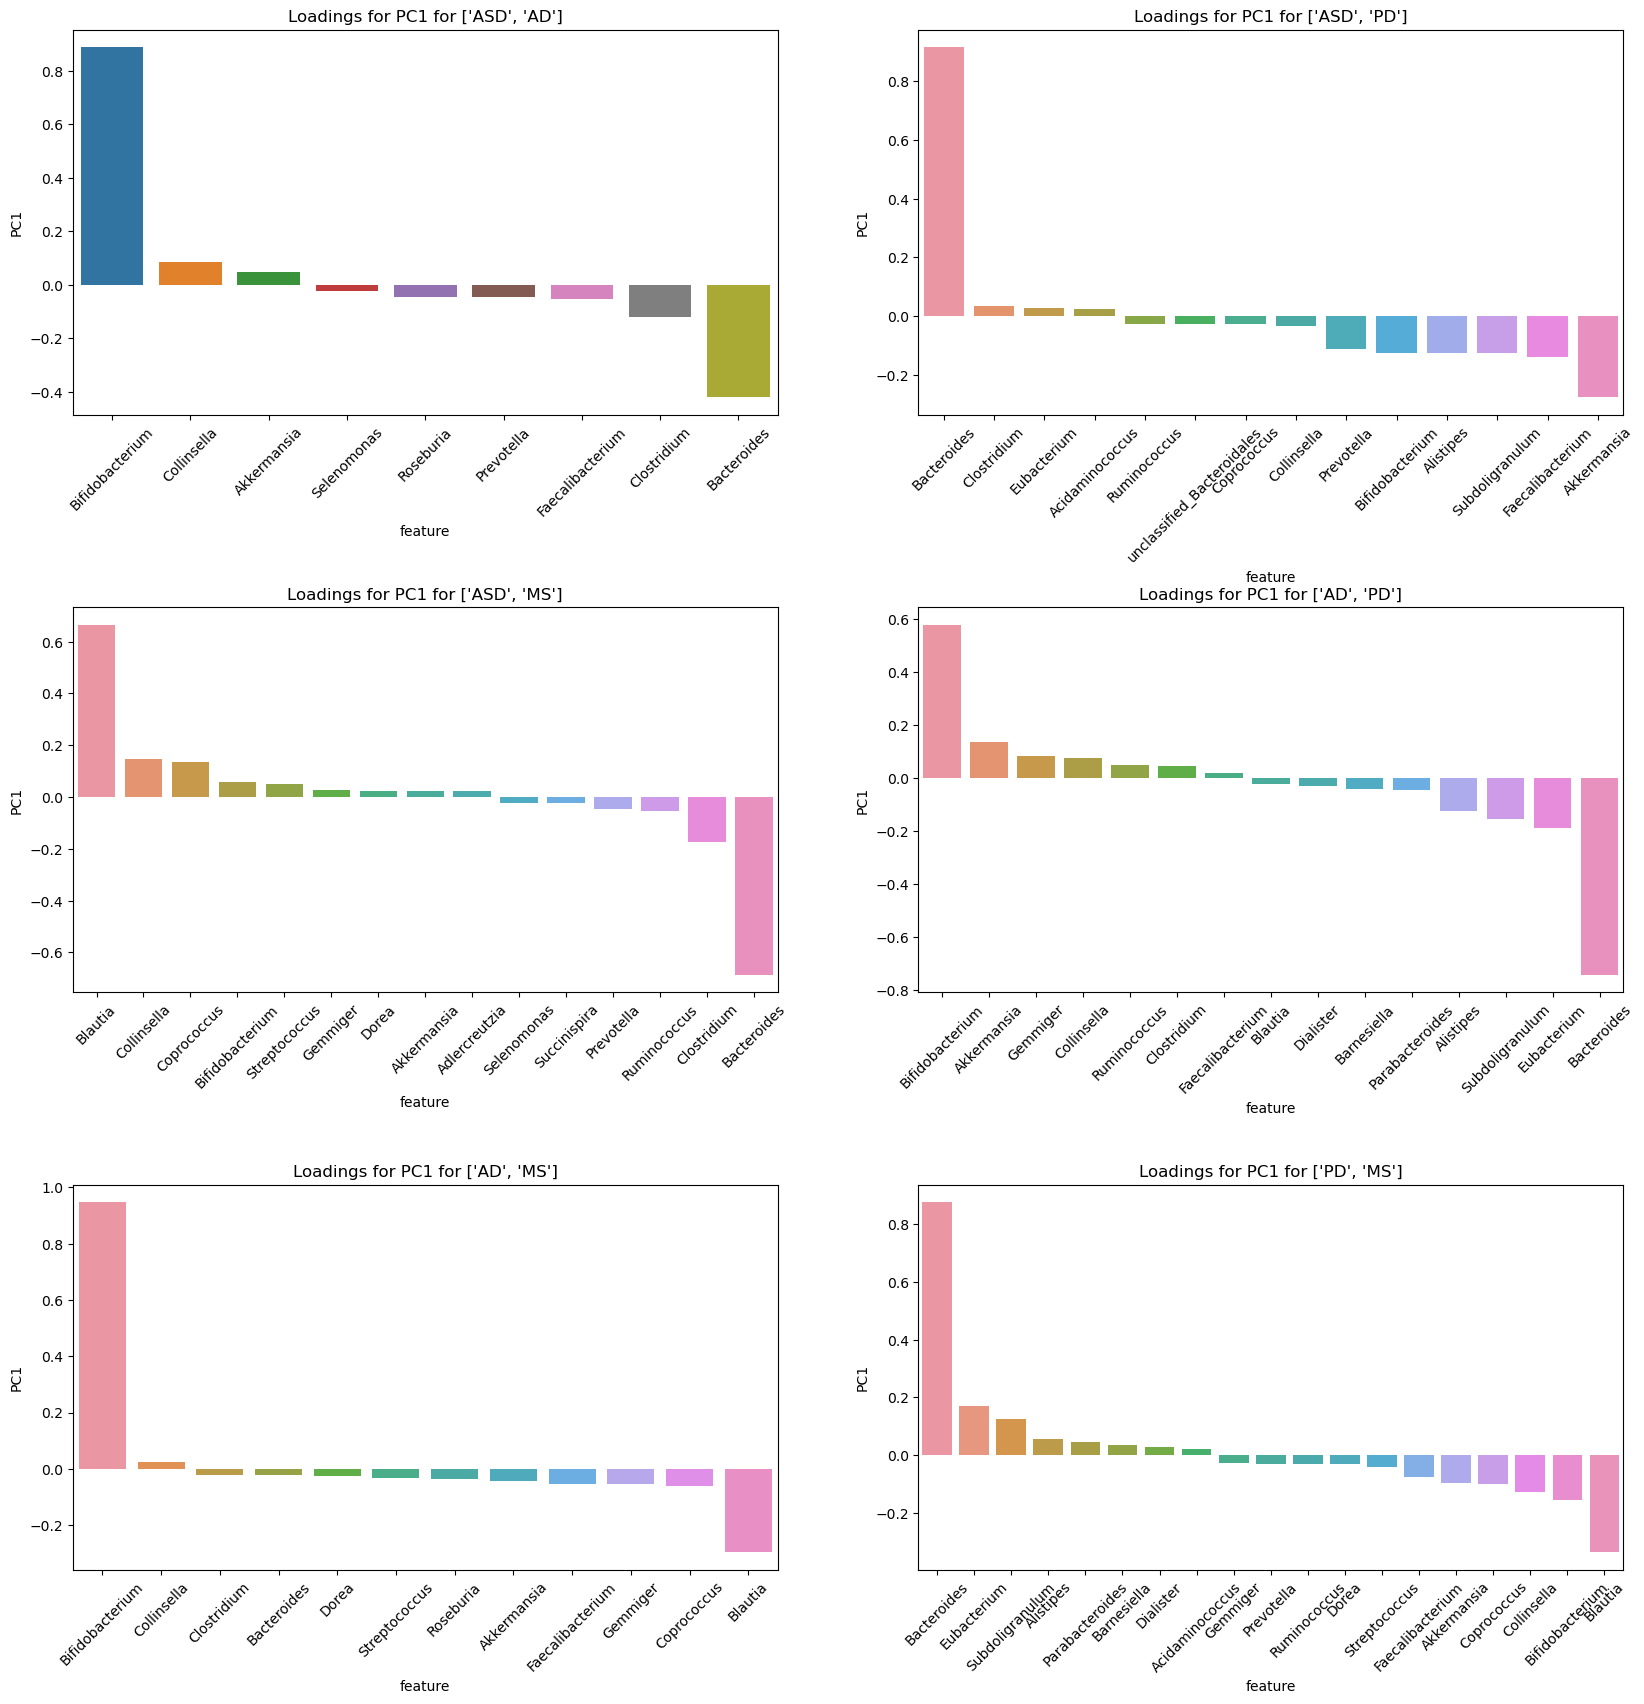

In [9]:
plt.figure(dpi = 200)
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2, figsize=(20, 20))
axes = [ax1, ax2, ax3, ax4, ax5, ax6]
plt.subplots_adjust(hspace=.5)

for i in range(len(pcs_pair)):
    pcs = pcs_pair[i]
    # create a dataframe with the load of the features in PC1:
    load = pd.DataFrame(np.transpose(pcs), columns=['PC'+str(i+1) for i in range(len(out_df_pair[i].columns))])
    load["feature"] = list(data_pair[i].columns)
    
    # descending values
    load1 = load.sort_values('PC1', ascending=False)
    load1_feat = pd.DataFrame(load1[["feature", 'PC1']], columns=['feature', 'PC1']) # for reference
    
    for feat in pairwise[i]:
        load1_feat = load1_feat.loc[(load1_feat['PC1'] > .02) | (load1_feat['PC1'] < -.02)]
    
    # plot
    sns.barplot(load1_feat, x='feature', y='PC1', ax=axes[i]);
    axes[i].set_xticklabels(load1_feat['feature'], rotation=45);
    axes[i].set_title("Loadings for PC1 for " + str(pairwise[i]));

plt.savefig('../Figures/PCA_load_plots_paired.svg')

## Biplot creation

## TSNE Analysis

**Run TSNE**

This will be done on the already reduced dimension dataset produced by PCA:

In [ ]:
# set up lists of diagnoses indices:
plt.figure(dpi = 200)
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2, figsize=(20, 20))
axes = [ax1, ax2, ax3, ax4, ax5, ax6]

for i in range(len(out_df_pair)):
    
    X_embedded = TSNE(n_components=2, learning_rate='auto', 
                  init='random', perplexity=50, n_iter=3000).fit_transform(out_df_pair[i])
    TSNE_df = pd.DataFrame(X_embedded)
    
    diag_1 = []
    diag_2 = []
    
    for j in range(len(diagnosis_pair[i])):
        if diagnosis_pair[i][j]==pairwise[i][0]:
            diag_1.append(j)
        if diagnosis_pair[i][j]==pairwise[i][1]:
            diag_2.append(j)
    
    # plot PC1 v PC2, indicating which indices of these are which disease:
    axes[i].scatter(TSNE_df[0][diag_1], TSNE_df[1][diag_1], label=pairwise[i][0], color = color_map[pairwise[i][0]], edgecolor='white')
    axes[i].scatter(TSNE_df[0][diag_2], TSNE_df[1][diag_2], label=pairwise[i][1], color = color_map[pairwise[i][1]], edgecolor='white')
    
    
    axes[i].legend();
    axes[i].set(xlabel="TSNE1")
    axes[i].set(ylabel="TSNE2")
    axes[i].set_title("TSNE of " + str(pairwise[i]));
plt.savefig('../Figures/TSNE_plots_paired.svg')


## RF Classifier

In [ ]:
diag_test_pair = []
diag_train_pair = []
out_pair = []
diag_predict_pair = []
rf_pair = []

for i in range(len(data_pair)):
    # set up classifier
    rf = RandomForestClassifier(n_estimators=100) # 100 trees in the forest.
    # 100 trees means 100 sub-samples of data
    
    # make training and testing sets:
    feat_train, feat_test, diag_train, diag_test = sk.model_selection.train_test_split(data_pair[i], diagnosis_pair[i], test_size=0.5)
    # chose a test size of 30%
    
    # train:
    out = rf.fit(feat_train, diag_train)
    
    # test:
    diag_predict = rf.predict(feat_test)

    diag_test_pair.append(diag_test)
    diag_train_pair.append(diag_train)
    out_pair.append(out)
    diag_predict_pair.append(diag_predict)
    rf_pair.append(rf)

**Accuracy of classifier**

In [ ]:
for i in range(len(diag_test_pair)):
    acc = sk.metrics.accuracy_score(diag_test_pair[i], diag_predict_pair[i])
    print("accuracy of the classifier: {}".format(acc))

**Table of importances**

In [ ]:
imp_table_pair = []
df_imp = []
for i in range(len(data_pair)):
    # find importance of each feature:
    feat = data_pair[i].columns
    feat_importance = rf_pair[i].feature_importances_
    
    # make and print table of ranked features by importance:
    imp_table = pd.DataFrame(feat, columns=['features'])
    imp_table['importance'] = feat_importance
    imp_table_sort = imp_table.sort_values('importance', ascending=False)
    feat_sort = list(imp_table_sort['features']) # use this for plotting and storing the features
    imp_table_pair.append(feat_sort)
    df_imp.append(imp_table_sort)
    imp_table_sort.to_csv('../Data/feature_importance/' + "feature_importance_" + pairwise[i][0] + '_' + pairwise[i][1] + '.csv')  

In [ ]:
df_imp[5]

**XY scatter of important features**

In [ ]:
plt.figure(dpi = 200)
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2, figsize=(20, 20))
axes = [ax1, ax2, ax3, ax4, ax5, ax6]

for i in range(len(data_pair)):

    diag_1 = []
    diag_2 = []

    feat1 = imp_table_pair[i][0]
    feat2 = imp_table_pair[i][1]
    
    for j in range(len(data_pair[i])):
        if diagnosis_pair[i][j]==pairwise[i][0]:
            diag_1.append(j)
        if diagnosis_pair[i][j]==pairwise[i][1]:
            diag_2.append(j)
    
    # use the top two most important features from the table of ranked importances

    axes[i].scatter(data_pair[i].reset_index()[feat1][diag_1], data_pair[i].reset_index()[feat2][diag_1], label=pairwise[i][0], color = color_map[pairwise[i][0]], edgecolor='white')
    axes[i].scatter(data_pair[i].reset_index()[feat1][diag_2], data_pair[i].reset_index()[feat2][diag_2], label=pairwise[i][1], color = color_map[pairwise[i][1]], edgecolor='white')
    
    axes[i].legend()
    
    axes[i].set(xlabel=feat1);
    axes[i].set(ylabel=feat2);
    axes[i].set_title("Classification on " + str(feat1) + " v. " + str(feat2));
plt.savefig('../Figures/RF_feature_plots_paired.svg')

**Look at Gini importance and get decision tree**

In [ ]:
# followed this tutorial for getting image: https://naysan.ca/2019/11/26/visualize-a-decision-tree-with-sklearn/
# i just plotted one of the trees:
graphs = []
Images = []
for i in range(len(out_pair)):
    out_file = sk.tree.export_graphviz(out_pair[i][1], label='all', feature_names=imp_table_pair[i], class_names= pairwise[i])
    
    graphs.append(pydotplus.graph_from_dot_data(out_file))
    Images.append(Image(graphs[i].create_png()))